In [89]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('17iO0rBs-gOFSUPbr6nd3IyfcKR-j2yYa')

# Cancer Mortality rate prediction for US counties using feedfoward neural networks

Using data aggregated from the American Community Survey (https://census.gov), https://hclinicaltrials.gov, and https://cancer.gov. 

Link of aggregated data can be found here: https://data.world/nrippner/ols-regression-challenge

# ABSTRACT

This project aims to predict cancer mortality rates of US counties, using feedfoward neural networks. We'll first start by downloading and cleaning the data. Then we'll perform some exploratory data analyses to look for trends. We'll then build a model with the dataset, which takes a bunch of inputs and returns predictions for target death rate. Finally, we'll examine how how our model performed against The data

## type of data: 

    tabular data
    
 ## Model used:
 
     Regression with feed-forward neural networks

# Introduction

Cancer is the second leading cause of death in the united states. Various types of cancer have been associated with modifiable risk factors like smoking, lack of physical activity, obesity, etc. Because modifiable risk factors have a very large association with the risk of developing cancers, half of cancer may be preventable (Colditz et al, 1996).


However, individual risk factors might not be the only modifiable risk factors for cancer. Parameters like poor access to health care, low income etc, should also be considered as potential indirect risk factors. It's no wonder, areas with better cancer detection centers, tend to have a lower rate of cancer mortality, thanks to early detection.

The dataset used in this project mainly contains population features of US counties, which will be fed into our model, in order to predict how these features might affect cancer mortality rates of US counties.

## Note

A copy of the dataset on my local drive will be used. However, I'll leave the download url to the dataset below. if you wish to explore on your own machine, simply uncomment the download_url function and replace the read_csv path with your path

In [90]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [91]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [92]:
# Hyperparameters
batch_size=16
learning_rate=5e-7


# Other constants
DATASET_URL = "https://data.world/nrippner/ols-regression-challenge/file/cancer_reg.csv"
DATA_FILENAME = "cancer.csv"
TARGET_COLUMN = 'target_deathrate'
input_size=13
output_size=1

## Dataset loading and cleaning

Here, We'll load our datasets into to dataframe variable and clean the data by searching for null cells

In [93]:
# Download the data
#download_url(DATASET_URL, '.')
dataframe = pd.read_csv(r'C:\Users\User\Desktop\drdata\cancer.csv', encoding = "ISO-8859-1")
dataframe = dataframe[['avgAnnCount', 'avgDeathsPerYear', 'TARGET_deathRate', 'incidenceRate', 'povertyPercent', 'MedianAge', 'PctEmpPrivCoverage', 'PctPublicCoverage', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate']]
dataframe.isnull().sum().sum()


0

As shown above, We'll be working with 14 columns from our data, 13 of which will be input columns for our model.

Also, our data has no null values, since it had been cleaned beforehand



## Exploratory Data Analyses

Let's try finding correlations between the input columns and Target Death rate

To avoid clogging up this notebook, I have plotted only a handful of graphs.

## Correlation between povertyPercent and TARGET deathrate

The plot below, shows a positive correlation between the percentage of poor people in individual US counties, and target death rate. 


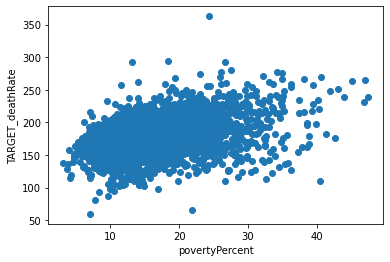

In [94]:
#correlation between povertyPercent and TARGET_deathRate
plt.scatter(dataframe['povertyPercent'], dataframe['TARGET_deathRate'])
plt.xlabel('povertyPercent')
plt.ylabel('TARGET_deathRate')
plt.show()

## Correlation between percentage empirc coverage and TARGET deathrate

The plot below, shows a negative correlation between the percentage of Empiric coverage for individual US counties, and target death rate. 

Generally, counties that have higher percentage of empiric coverage tend to experience lower death rates.

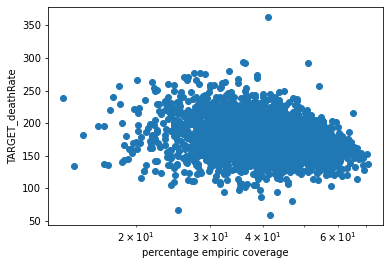

In [95]:
#correlation between median age and TARGET_deathRate
plt.scatter(dataframe['PctEmpPrivCoverage'], dataframe['TARGET_deathRate'])
plt.xlabel('percentage empiric coverage')
plt.ylabel('TARGET_deathRate')
plt.xscale('log')

plt.show()

## Correlation between percentage public coverage and TARGET deathrate

The plot below, shows that there might be positive correlation between the percentage of public coverage for individual US counties, and target death rate. 


As shown, counties that have higher percentage of public coverage tend to experience higher death rates. What could be a reasonable explanation for this?

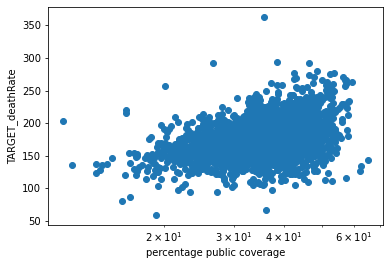

In [96]:
#correlation between percentage public coverage and TARGET_deathRate
plt.scatter(dataframe['PctPublicCoverage'], dataframe['TARGET_deathRate'])
plt.xlabel('percentage public coverage')
plt.ylabel('TARGET_deathRate')
plt.xscale('log')
plt.show()

### Converting data to PyTorch dataset

Lets' now convert our dataset to a pytorch data set, to enable us feed it to models


In [97]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('TARGET_deathRate', axis=1).values
targets = dataframe[['TARGET_deathRate']].values
inputs.shape, targets.shape
rown = dataframe.shape[0]
0.8 * rown, 0.2 * rown

(2437.6, 609.4)

In [98]:
## convert to pytorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))

train_ds, val_ds = random_split(dataset, [2437, 610])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

In [99]:
input_size = 13
output_size = 1

In [100]:
!pip install jovian --upgrade --quiet
import jovian
jovian.commit(project='us-counties-cancer-death-rate-prediction')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "sadiqbasit782/us-counties-cancer-death-rate-prediction"
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/abdulbee/us-counties-cancer-death-rate-prediction-8a48d


'https://jovian.ai/abdulbee/us-counties-cancer-death-rate-prediction-8a48d'

## Model
To train our our model, we'll be using a feed-foward neural network with 3 hidden layers. 

We'll be using the Relu function as the non-linear activation function for the hidden layers

Let's now define our models.

In [101]:
class LifeExpectancyModel(nn.Module):
    """Feedfoward neural network with 3 hidden layers"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 64)
        self.linear3 = nn.Linear(64, 128)
        # output layer
        self.linear4 = nn.Linear(128, out_size)
        
    def forward(self, xb):

        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Generate predictions
        loss = F.l1_loss(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Generate predictions
        loss = F.l1_loss(out, targets)   # Calculate loss
        acc = accuracy(out, targets)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))


In [102]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [103]:
model = LifeExpectancyModel(13, 32, 1)

## Training

Let's now define our evaluate and fit functions

We'll then train our model and improve it by varying our hyperparameters

In [104]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history


In [105]:
result = evaluate(model, val_loader)
result

{'val_loss': 169.96902465820312}

In [106]:
epochs = 100
lr = 1e-5

In [107]:
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 18.6959
Epoch [40], val_loss: 18.4128
Epoch [60], val_loss: 18.2030
Epoch [80], val_loss: 18.4281
Epoch [100], val_loss: 16.9023


In [108]:
epochs = 200
lr = 1e-5
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 16.4755
Epoch [40], val_loss: 15.7217
Epoch [60], val_loss: 15.9500
Epoch [80], val_loss: 14.9139
Epoch [100], val_loss: 15.0805
Epoch [120], val_loss: 15.1283
Epoch [140], val_loss: 19.4718
Epoch [160], val_loss: 14.1801
Epoch [180], val_loss: 14.1439
Epoch [200], val_loss: 13.6768


In [109]:
epochs = 300
lr = 1e-7
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13.6234
Epoch [40], val_loss: 13.6126
Epoch [60], val_loss: 13.6180
Epoch [80], val_loss: 13.6067
Epoch [100], val_loss: 13.6168
Epoch [120], val_loss: 13.6010
Epoch [140], val_loss: 13.6004
Epoch [160], val_loss: 13.5972
Epoch [180], val_loss: 13.5948
Epoch [200], val_loss: 13.5891
Epoch [220], val_loss: 13.5832
Epoch [240], val_loss: 13.5870
Epoch [260], val_loss: 13.6018
Epoch [280], val_loss: 13.5707
Epoch [300], val_loss: 13.5614


In [110]:
loss_final = 13.5614

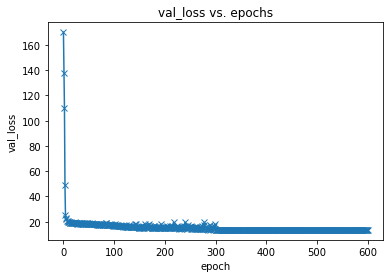

In [111]:
losses = [r['val_loss'] for r in [result] + history1 + history2 + history3]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction
Let's now take a look at a couple of predictions to see how our well our model did

In [112]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [113]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([1.4240e+03, 6.7200e+02, 4.4490e+02, 2.0800e+01, 4.9200e+01, 2.5000e+01,
        5.2900e+01, 8.9046e+01, 1.1271e+00, 1.2279e+00, 2.9352e+00, 4.8439e+01,
        4.5758e+00])
Target:  196.60000610351562
Prediction: 200.5573272705078


In [114]:
for i in range(100, 200):
    x, target = val_ds[i]
    pred = predict_single(x, model)
    print("Input: ", x)
    print("Target: ", target.item())
    print("Prediction:", pred)
    print('\n\n')

Input:  tensor([ 15.0000,   7.0000, 330.7000,  26.5000,  40.8000,  37.4000,  43.9000,
         93.5389,   0.5140,   0.7832,   4.4787,  61.1316,  11.5566])
Target:  156.8000030517578
Prediction: 149.3185577392578



Input:  tensor([1.2500e+02, 5.3000e+01, 4.9460e+02, 1.8100e+01, 3.8900e+01, 4.3800e+01,
        3.9400e+01, 7.6655e+01, 2.1439e+01, 9.2904e-02, 3.0968e-02, 5.7336e+01,
        4.1799e+00])
Target:  212.39999389648438
Prediction: 204.2766571044922



Input:  tensor([145.0000,  64.0000, 375.6000,  16.1000,  29.1000,  39.4000,  28.8000,
         68.9838,  25.3648,   0.7721,   1.9805,  54.3948,   4.7607])
Target:  163.10000610351562
Prediction: 168.67941284179688



Input:  tensor([ 49.0000,  24.0000, 437.7000,  32.5000,  36.8000,  27.9000,  48.2000,
         28.8711,  70.6581,   0.0000,   0.4708,  36.0548,   2.7902])
Target:  219.6999969482422
Prediction: 208.0584716796875



Input:  tensor([9.1000e+01, 3.7000e+01, 4.1950e+02, 1.9000e+01, 4.0900e+01, 3.3500e+01,
        3.8100e

Input:  tensor([406.0000, 158.0000, 482.4000,  14.4000,  37.9000,  48.0000,  31.3000,
         75.5160,  21.2189,   0.5163,   0.6785,  54.3262,   5.8001])
Target:  193.8000030517578
Prediction: 182.8050537109375



Input:  tensor([5.7000e+01, 2.5000e+01, 4.0130e+02, 1.0700e+01, 3.1300e+01, 4.8600e+01,
        2.3400e+01, 9.2340e+01, 1.9613e+00, 3.7556e-01, 2.2891e+00, 6.2710e+01,
        1.0782e+01])
Target:  182.1999969482422
Prediction: 164.51553344726562



Input:  tensor([3.3000e+01, 1.7000e+01, 4.4810e+02, 1.0000e+01, 4.2800e+01, 4.5900e+01,
        2.9000e+01, 9.6775e+01, 3.7413e-01, 0.0000e+00, 7.8389e-01, 5.6991e+01,
        7.1914e+00])
Target:  202.5
Prediction: 180.6067657470703



Input:  tensor([3.4000e+01, 1.2000e+01, 3.9230e+02, 1.1400e+01, 3.0000e+01, 5.3000e+01,
        2.5500e+01, 9.4577e+01, 1.0577e-01, 2.7885e-01, 2.6731e+00, 6.7643e+01,
        6.4404e+00])
Target:  136.89999389648438
Prediction: 154.45974731445312



Input:  tensor([2.0800e+02, 8.2000e+01, 4.5170e

Input:  tensor([6.0000e+01, 2.5000e+01, 4.4230e+02, 1.1500e+01, 4.2900e+01, 4.3100e+01,
        3.4900e+01, 9.7198e+01, 1.2598e+00, 4.0182e-01, 1.0860e-01, 5.2929e+01,
        4.6901e+00])
Target:  152.60000610351562
Prediction: 175.3107147216797



Input:  tensor([2.1800e+02, 7.2000e+01, 5.7280e+02, 1.4800e+01, 5.2600e+01, 3.0200e+01,
        5.0400e+01, 8.6570e+01, 3.9803e-01, 5.1510e-01, 3.5589e-01, 5.0648e+01,
        4.6933e+00])
Target:  177.0
Prediction: 186.85292053222656



Input:  tensor([242.0000, 113.0000, 442.2000,  20.3000,  38.2000,  36.0000,  37.2000,
         76.7758,  13.6352,   0.6796,   3.2857,  51.0156,   7.9367])
Target:  201.89999389648438
Prediction: 203.56265258789062



Input:  tensor([7.4100e+02, 3.0800e+02, 4.7840e+02, 1.3800e+01, 4.4000e+01, 4.4800e+01,
        3.9200e+01, 9.6006e+01, 7.9018e-01, 7.7119e-01, 4.0624e-01, 4.7202e+01,
        4.8237e+00])
Target:  193.1999969482422
Prediction: 189.06369018554688



Input:  tensor([2.8090e+03, 9.6500e+02, 4.733

In [115]:
torch.save(model.state_dict(), 'cancer-rate-feedforward.pth')

## Conclusion

In this project, We have analyzed the US counties datasets and tried to find links between various parameters and death rate.

We also built a model Using feed-forward neural networks, which predicts targets cancer death-rates, based on given parameters.

However, there's still a wealth of information that can be dug out of this dataset.

Also, the model didn't measure the accuracy of our predictions because measurement of accuracy in this case is subjective (since we're dealing with values here) and would have to be based on individually defined criteria.

A good improvement to this model, will be to set a function that calculates the accuracy based on how far the predictions are from the actual target death rate. for example, you could objectively decide that any prediction that's less than 20 death rates from the actual death rate, would be classified as an accurate prediction. that way, you'll have an objective measure of exactly how accurate the model is.

## Reference

https://data.world/nrippner/ols-regression-challenge

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2410150/

## Save and upload

Let's save and upload our notebook, model and metrics

### Let's log in our metrics


In [117]:
jovian.log_metrics(final_loss = loss_final, hidden_layers = 3, lr1 = 1e-5, epoch1 = 100, lr2 = 1e-5, epoch2 = 200, lr3 = 1e-7, epoch3 =300)

[jovian] Metrics logged.


In [118]:
jovian.commit(project='us-counties-cancer-death-rate-prediction', 
              environment=None, 
              outputs=['cancer-rate-feedforward.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "sadiqbasit782/us-counties-cancer-death-rate-prediction"
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/abdulbee/us-counties-cancer-death-rate-prediction-d60f0


'https://jovian.ai/abdulbee/us-counties-cancer-death-rate-prediction-d60f0'